# Homework 6
Name: Stanly Gomes

Student ID: 801118166

GitHub Repository: https://github.com/stanlygomes/RealTimeML

## Import Modules and Methods

In [ ]:
# Using D2L
!pip install setuptools==66 --quiet
!pip install d2l==1.0.0b0 --quiet
!pip install ptflops==0.1 --quiet

In [2]:
import collections
import random
import re
import torch
from d2l import torch as d2l
from ptflops import get_model_complexity_info
import math
from torch import nn
from torch.nn import functional as F
from datetime import datetime

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

In [3]:
# Import data
data = d2l.MTFraEng(batch_size=128)

### Transformer-related Classes

In [4]:
# Transformer Architecture Methods from D2L
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class AddNorm(nn.Module):
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [5]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

class TransformerEncoder(d2l.Encoder):
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [6]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
        
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

### Vision Transformer-related Classes

In [15]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

In [23]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))

In [16]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

In [17]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

## Problem 1: Train varying depths of Transformer-based models

256 Hidden Layers training time: 0:00:38.648477
512 Hidden Layers training time: 0:00:49.020494
768 Hidden Layers training time: 0:00:47.886128


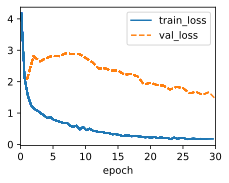

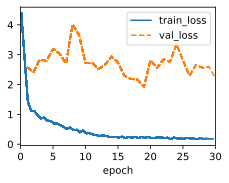

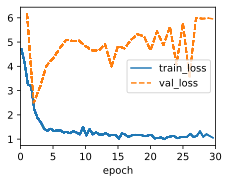

In [8]:
# Variables for tracking model variance in depth
num_hidden_list = [256, 256*2, 256*3]
num_blks, dropout = 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
model_times = []

models = []

# Training loop to run each varying-depth Transformer model
for num_hiddens in num_hidden_list:
  # Define encoder and decoder with the current num_hiddens
  encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
  decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
  
  model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
  
  # Start training timer and actual training loop of model
  trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
  start_time = datetime.now()
  trainer.fit(model, data)
  end_time = datetime.now()

  model_times.append(end_time - start_time)
  models.append(model)
for num_hiddens, times in zip(num_hidden_list, model_times):
  print(f"{num_hiddens} Hidden Layers training time: {times}")

In [13]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for model, num_hiddens in zip(models, num_hidden_list):
  print('')
  print(f'{num_hiddens} Hidden Layer Model Predictions:')
  preds, _ = model.predict_step(
      data.build(engs, fras), d2l.try_gpu(), data.num_steps)
  for en, fr, p in zip(engs, fras, preds):
      translation = []
      for token in data.tgt_vocab.to_tokens(p):
          if token == '<eos>':
              break
          translation.append(token)
      print(f'{en} => {translation}, bleu,'
            f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')


256 Hidden Layer Model Predictions:
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', 'tard', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000

512 Hidden Layer Model Predictions:
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'calme', '.'], bleu,1.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000

768 Hidden Layer Model Predictions:
go . => ['<unk>', '!'], bleu,0.000
i lost . => ['je', 'suis', '.'], bleu,0.000
he's calm . => ['je', 'suis', 'suis', 'suis', 'suis', 'suis', 'suis', 'suis', 'suis'], bleu,0.000
i'm home . => ['je', 'suis', 'suis', 'suis', 'suis', 'suis', 'suis', 'suis', 'suis'], bleu,0.280


### Problem 1:

As it can been seen from above, the training speed slightly increased while increasing the model complexity drastically. Based on the translations performed with each model, the deeper models performed much worse in quality.

## Problem 2: Vision Transformers

In [ ]:
img_size, patch_size = 96, 16
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))

In [21]:
num_hidden_list = [256, 256*2]
num_blks_list = [2, 4]
mlp_num_hiddens, num_heads = 2048, 8
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model_times = []

models = []

256 Hidden Layers training time: 0:04:07.965378
512 Hidden Layers training time: 0:05:29.844502


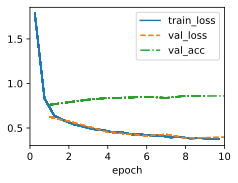

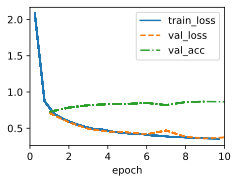

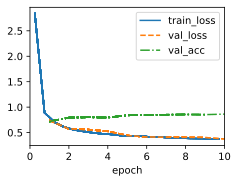

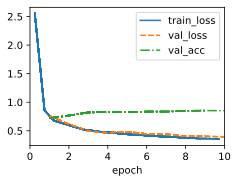

In [24]:
# Training loop to run each varying-depth Vision Transformer model
for num_hiddens in num_hidden_list:
  for num_blks in num_blks_list:
    # Define model with the current num_hiddens and num_blks
    model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
    
    # Start training timer and actual training loop of model
    trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
    start_time = datetime.now()
    trainer.fit(model, data)
    end_time = datetime.now()

    model_times.append(end_time - start_time)
    models.append(model)

In [31]:
i = 0
for num_hiddens in num_hidden_list:
  i += 0
  for num_blks in num_blks_list:
    print(f"{num_hiddens} Hidden Layers, {num_blks} Blocks training time: {model_times[i]}")
    i += 1

256 Hidden Layers, 2 Blocks training time: 0:04:07.965378
256 Hidden Layers, 4 Blocks training time: 0:05:29.844502
512 Hidden Layers, 2 Blocks training time: 0:05:32.942447
512 Hidden Layers, 4 Blocks training time: 0:10:07.201741


### Problem 2:

As it can be seen, the training time increases drastically when number of hidden layers and blocks are doubled. Along with this, the model is more complex due to the increase in blocks/hidden layers. Lastly, the validation accuracy seems to have slightly increased as the model became more complex.